**Реализовать алгоритм эмпирического упорядочивания вероятностей элемен
тарных событий, не изменяющихся в процессе испытаний (§3.3.2, 3.3.3), с
возможностью задавать вероятность, контролировавшую исход испытаний, и при
разных вероятностях ошибочного упорядочения. Результатом работы программы
должны быть:**

1. упорядоченная по вероятности последовательность элементарных событий,
2. график зависимости числа потребовавшихся испытаний от вероятности ошибочного упорядочения,
3. интервальные оценки вероятностей элементарных событий для максимального
использованного числа испытаний и нескольких значений вероятности ошибоч
ного упорядочения.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [246]:
def generate_distrubution(s: int, seed=42) -> list[float]:
    '''
    Генерирует массив размера s вероятностей (истинных).
    Сумма вероятностей равна 1.
    '''
    np.random.seed(seed)
    true_proba = np.random.uniform(size=s)
    true_proba = true_proba / true_proba.sum()
    return np.sort(true_proba)[::-1]


def get_proba_randomly(true_proba: list[float], n: int) -> int:
    '''
    Генерирует результат в испытаниях рандомно.
    Возвращает массив из индексов событий
    '''
    return np.random.choice(len(true_proba), n, p=true_proba, replace=True)


def fill_indicator_function(true_proba: list, n: int, seed = 42):
    '''
    Получить результаты следующих n испытаний
    '''
    np.random.seed(seed)
    s = len(true_proba)
    ans = np.zeros((n, s), dtype=np.int8)
    ind_proba = get_proba_randomly(true_proba, n)
    for i in range(n):
        for j in range(s):
            if j == ind_proba[i]:
                ans[i][j] = 1
            else:
                ans[i][j] = 0
    return ans


def recreate_possibilities(true_proba: list[float], indicator_function: np.array, alpha: float) -> tuple[int, np.array]:
    '''
    Алгоритм, восстанавливающий возможности в эксперименте с
    НЕизменяющимися вероятностями. Возвращает кол-во шагов и упорядоченную по вероятностям последовательность
    '''
    s = len(true_proba)
    
    alpha_s = alpha / (s - 1)
    # indicator_function = [[] for _ in range(s)]
    pr_cross = np.zeros((s, s), dtype=np.int8) # Взаимное расположение частот (попарное)
    
    # Сам алгоритм
    n = 0
    to_continue = True
    while to_continue:
        to_continue = False
        n += 1
        
        # Генерируем новые испытания, если не хватает
        assert len(indicator_function) >= n, "N more than len of indicator_function"
            # fill_indicator_function(true_proba, indicator_function, 100)
        
        delta_n_s = (2 / n * math.log(2 / alpha_s))**0.5
        
        # Чекаем шаги
        for i in range(s):
            for k in range(i):
                nu_i_k = 1/n * sum([x1 - x2 for x1, x2 in zip(indicator_function[:n, i], indicator_function[:n, k])]) 
                # print(nu_i_k, delta_n_s)
                if nu_i_k > delta_n_s:
                    pr_cross[i][k] = 1 # pr_i_k > 0
                    pr_cross[k][i] = -1
                elif nu_i_k < -delta_n_s:
                    pr_cross[i][k] = -1 # pr_i_k < 0
                    pr_cross[k][i] = 1
                else:
                    to_continue = True
                    # print(f"Algo circle at k={k}")
                    break
            if to_continue:
                break
        
    # Извлекаем упорядоченную последовательность
    result = np.zeros(s, dtype=np.int8)
    for i in range(s):
        position = 0
        for k in range(s):
            if (pr_cross[i][k] == -1):
                position += 1
        result[position] = i
    
    return n, result

In [247]:
S = 4
alpha_arr = np.logspace(-2, 0, base=10, num=10)
NUM_ALPHA = len(alpha_arr)

true_proba = generate_distrubution(S)
indicator_function = fill_indicator_function(true_proba, 100_000)

# print(indicator_function.shape)
result_arr = []

for alpha in alpha_arr:
    n, recreated_seq = recreate_possibilities(true_proba, indicator_function, alpha)
    print(f"alpha={round(alpha, 2)}, sequence: {recreated_seq}")
    if (recreated_seq == np.arange(S, dtype=np.uint8)[::-1]).all():
        color = "red"
    else:
        color = "blue"
    
    result_arr.append((n, color))


alpha=0.01, sequence: [0 1 2 3]
alpha=0.02, sequence: [0 1 2 3]
alpha=0.03, sequence: [0 1 2 3]
alpha=0.05, sequence: [0 1 2 3]
alpha=0.08, sequence: [0 1 2 3]
alpha=0.13, sequence: [0 1 2 3]
alpha=0.22, sequence: [0 1 2 3]
alpha=0.36, sequence: [0 1 2 3]
alpha=0.6, sequence: [0 1 2 3]
alpha=1.0, sequence: [0 1 2 3]


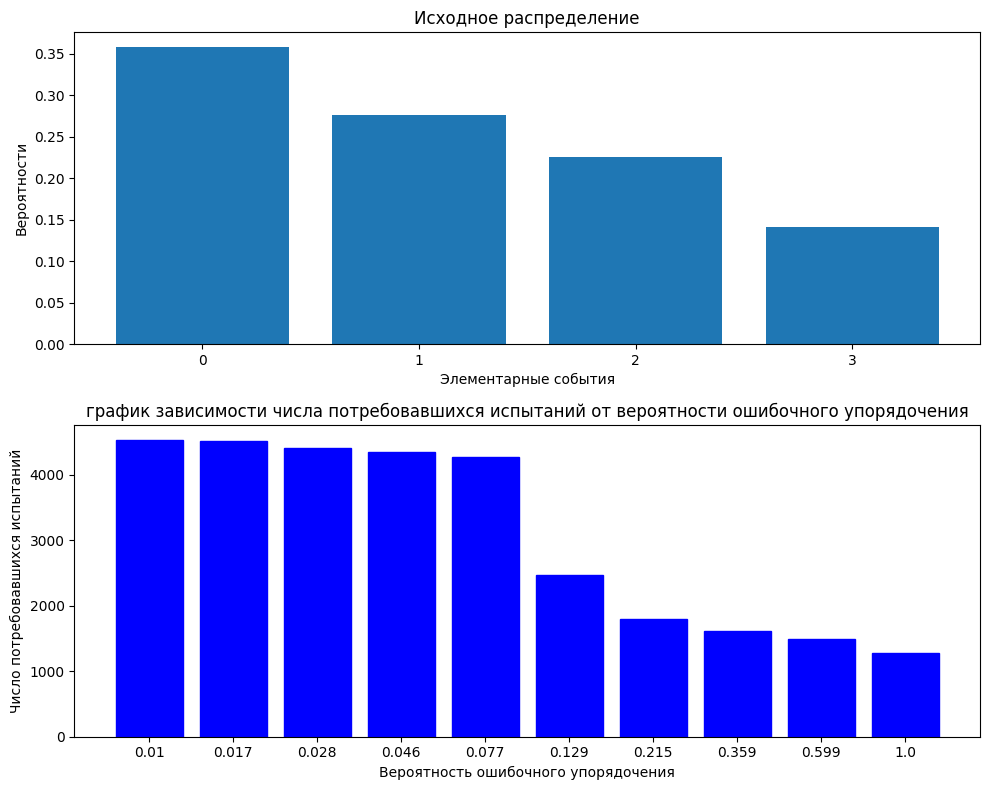

In [248]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)

ax1.bar(range(S), true_proba)
ax1.set_xticks(range(S), range(S))
ax1.set_ylabel("Вероятности")
ax1.set_xlabel("Элементарные события")
ax1.set_title("Исходное распределение")

bars = ax2.bar(
    range(NUM_ALPHA),
    [x[0] for x in result_arr]
)

for i, result in enumerate(result_arr):
    bars[i].set_color(result[1])
    
ax2.set_xticks(range(NUM_ALPHA)[::1], np.round(alpha_arr, 3)[::1])
ax2.set_ylabel("Число потребовавшихся испытаний")
ax2.set_xlabel("Вероятность ошибочного упорядочения")
ax2.set_title("график зависимости числа потребовавшихся испытаний от вероятности ошибочного упорядочения")
plt.show()